This notebook is part of the PyImageJ [Tutorial Series](./notebooks.rst), and assumes familiarity with the ImageJ API. Dedicated tutorials for ImageJ can be found [here](https://imagej.net/tutorials/).

# 9 Visualizing large images

Before we begin: how much memory is Java using right now?

In [1]:
import imagej

ij = imagej.init(mode='interactive')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.9.0/1.53t


In [2]:
from scyjava import jimport
Runtime = jimport('java.lang.Runtime')
def java_mem():
    rt = Runtime.getRuntime()
    mem_max = rt.maxMemory()
    mem_used = rt.totalMemory() - rt.freeMemory()
    return '{} of {} MB ({}%)'.format(int(mem_used)/2**20, int(mem_max/2**20), int(100*mem_used/mem_max))

java_mem()

'45.811737060546875 of 16016 MB (0%)'

Now let's open an obnoxiously huge synthetic dataset:

In [3]:
big_data = ij.scifio().datasetIO().open('lotsofplanes&lengths=512,512,16,1000,10000&axes=X,Y,Channel,Z,Time.fake')

How many total samples does this image have?

In [4]:
import numpy as np

dims = [big_data.dimension(d) for d in range(big_data.numDimensions())]
pix = np.prod(dims)
str(pix/2**40) + " terapixels"

'38.14697265625 terapixels'

And how much did memory usage in Java increase?

In [5]:
java_mem()

'813.3113555908203 of 16016 MB (5%)'

Let's visualize this beast. First, we define a function for slicing out a single plane:

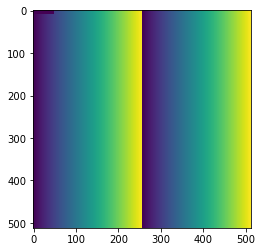

In [6]:
def plane(image, pos):
    while image.numDimensions() > 2:
        image = ij.op().transform().hyperSliceView(image, image.numDimensions() - 1, pos[-1])
        pos.pop()
    return ij.py.from_java(ij.py.to_img(image))

ij.py.show(plane(big_data, [0, 0, 0]))

But we can do better. Let's provide some interaction. First, a function to extract the _non-planar_ axes as a dict:

In [7]:
def axes(dataset):
    axes = {}
    for d in range(2, dataset.numDimensions()):
        axis = dataset.axis(d)
        label = axis.type().getLabel()
        length = dataset.dimension(d)
        axes[label] = length
    return axes

axes(big_data)

{'Channel': 16, 'Z': 1000, 'Time': 10000}

In [8]:
import matplotlib
import ipywidgets

widgets = {}
for label, length in axes(big_data).items():
    label = str(label) # HINT: Convert Java string to a python string to use with ipywidgets.
    widgets[label] = ipywidgets.IntSlider(description=label, max=length-1)

widgets

{'Channel': IntSlider(value=0, description='Channel', max=15),
 'Z': IntSlider(value=0, description='Z', max=999),
 'Time': IntSlider(value=0, description='Time', max=9999)}

In [9]:
def f(**kwargs):
    matplotlib.pyplot.imshow(plane(big_data, list(kwargs.values())), cmap='gray')
ipywidgets.interact(f, **widgets)

interactive(children=(IntSlider(value=0, description='Channel', max=15), IntSlider(value=0, description='Z', m…

<function __main__.f(**kwargs)>